In [143]:
%matplotlib inline

from math import sqrt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

In [144]:
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 40)
pd.set_option('display.precision', 4)

sns.set_style("darkgrid")
sns.set_context(rc={"figure.figsize": (8, 6)})

In [145]:
horsey = pd.read_csv('../data/horsey.csv', parse_dates=['round_date'])

In [146]:
print(horsey.iloc[0])

round_date                          2016-11-18 00:00:00
round_no                                              2
hole_no                                              13
shot_no                                               1
putt                                                NaN
completed                                          True
left_to_pin_before                                 7560
left_to_pin_after                                   360
penalty                                             NaN
player_name                                David Horsey
name                  DP World Tour Championship, Dubai
course_id                                            48
start_tee                                             1
score                                                 3
par                                                   3
yards                                               204
lie_after                                         Green
lie_before                                      

In [147]:
# inspect data

horsey.head()

,round_date,round_no,hole_no,shot_no,putt,completed,left_to_pin_before,left_to_pin_after,penalty,player_name,name,course_id,start_tee,score,par,yards,lie_after,lie_before,club,direction
0,2016-11-18,2,13,1,NaN,True,7560,360.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,3,3,204,Green,Tee,iron,center
1,2016-11-18,2,13,2,True,True,360,12.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,3,3,204,Green,Green,putter,short
2,2016-11-18,2,13,3,True,True,12,1.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,3,3,204,Hole,Green,putter,center
3,2016-11-18,2,18,1,NaN,True,19440,9324.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,4,5,620,Fairway,Tee,driver,center
4,2016-11-18,2,18,2,NaN,True,9324,2520.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,4,5,620,Fairway,Fairway,iron,center


In [148]:
# add some columns

df = horsey.copy()
df['is_putt'] = df['putt'] == True
df['score_norm'] = df['score'] - df['par']
df['hole_norm'] = df.apply(lambda r: (r['hole_no'] - r['start_tee']) % 18, axis=1)


# convert distance to pin to feet, yards, bins, etc.

def bin_num(x, base):
    if pd.isnull(x):
        return x
    return int(x - (x % base))

df['pre_ft'] = df['left_to_pin_before'] / 12.0
df['pre_yd'] = df['left_to_pin_before'] / 36.0
df['pre_ft_bin5'] = df['pre_ft'].apply(lambda x: bin_num(x, 5))
df['pre_yd_bin10'] = df['pre_yd'].apply(lambda x: bin_num(x, 10))
df['pre_yd_bin25'] = df['pre_yd'].apply(lambda x: bin_num(x, 25))

df['post_ft'] = df['left_to_pin_after'] / 12.0
df['post_yd'] = df['left_to_pin_after'] / 36.0
df['post_ft_bin5'] = df['post_ft'].apply(lambda x: bin_num(x, 5))
df['post_yd_bin10'] = df['post_yd'].apply(lambda x: bin_num(x, 10))
df['post_yd_bin25'] = df['post_yd'].apply(lambda x: bin_num(x, 25))

df.head()

,round_date,round_no,hole_no,shot_no,putt,completed,left_to_pin_before,left_to_pin_after,penalty,player_name,name,course_id,start_tee,score,par,yards,lie_after,lie_before,club,direction,is_putt,score_norm,hole_norm,pre_ft,pre_yd,pre_ft_bin5,pre_yd_bin10,pre_yd_bin25,post_ft,post_yd,post_ft_bin5,post_yd_bin10,post_yd_bin25
0,2016-11-18,2,13,1,NaN,True,7560,360.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,3,3,204,Green,Tee,iron,center,False,0,12,630.0,210.0000,630,210,200,30.0000,10.0000,30.0,10.0,0.0
1,2016-11-18,2,13,2,True,True,360,12.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,3,3,204,Green,Green,putter,short,True,0,12,30.0,10.0000,30,10,0,1.0000,0.3333,0.0,0.0,0.0
2,2016-11-18,2,13,3,True,True,12,1.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,3,3,204,Hole,Green,putter,center,True,0,12,1.0,0.3333,0,0,0,0.0833,0.0278,0.0,0.0,0.0
3,2016-11-18,2,18,1,NaN,True,19440,9324.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,4,5,620,Fairway,Tee,driver,center,False,-1,17,1620.0,540.0000,1620,540,525,777.0000,259.0000,775.0,250.0,250.0
4,2016-11-18,2,18,2,NaN,True,9324,2520.0,NaN,David Horsey,"DP World Tour Championship, Dubai",48,1,4,5,620,Fairway,Fairway,iron,center,False,-1,17,777.0,259.0000,775,250,250,210.0000,70.0000,210.0,70.0,50.0


In [149]:
# look at putting data

putts = df[(df.putt == True) & (df.club == 'putter')].copy()

putts['made_it'] = putts['lie_after'] == 'Hole'
putts['putts_needed'] = putts['score'] - putts['shot_no'] + 1

cols = [
    'round_date', 'round_no', 'hole_no', 'shot_no',
    'left_to_pin_before', 'left_to_pin_after', 'score', 'par', 'direction',
    'made_it', 'pre_ft', 'post_ft', 'putts_needed', 
]

putts = putts[cols]
putts.head(20)

,round_date,round_no,hole_no,shot_no,left_to_pin_before,left_to_pin_after,score,par,direction,made_it,pre_ft,post_ft,putts_needed
1,2016-11-18,2,13,2,360,12.0,3,3,short,False,30.0,1.0000,2
2,2016-11-18,2,13,3,12,1.0,3,3,center,True,1.0,0.0833,1
6,2016-11-18,2,18,4,72,1.0,4,5,center,True,6.0,0.0833,1
11,2016-11-19,3,2,5,48,1.0,5,5,center,True,4.0,0.0833,1
14,2016-11-19,3,1,3,216,1.0,3,4,center,True,18.0,0.0833,1
17,2016-11-19,3,3,3,600,60.0,4,4,long right,False,50.0,5.0000,2
18,2016-11-19,3,3,4,60,1.0,4,4,center,True,5.0,0.0833,1
20,2016-11-19,3,4,2,540,72.0,3,3,long right,False,45.0,6.0000,2
21,2016-11-19,3,4,3,72,1.0,3,3,center,True,6.0,0.0833,1
23,2016-11-10,1,9,4,324,12.0,5,5,left,False,27.0,1.0000,2


In [150]:
# compute make percent and fractional pars by foot

aggs = {
    'made_it': {
        'putts': len,
        'make': lambda x: sum(x) / len(x),
    },
    'putts_needed': {
        '1': lambda x: (x == 1).sum(),
        '2': lambda x: (x == 2).sum(),
        '3': lambda x: (x == 3).sum(),
    }
}

putt_stats = putts.groupby('pre_ft').agg(aggs).reset_index()

putt_stats['fractional_par'] = putt_stats.apply(
    lambda r: sum([
        r['putts_needed'][num] / r['made_it']['putts'] * float(num)
        for num in ['1', '2', '3']
    ]),
    axis=1
)

putt_stats[:20]

pre_ft made_it         putts_needed        fractional_par
            putts    make            1   2  3               
0     1.0     438  1.0000          438   0  0         1.0000
1     2.0      81  0.9877           80   1  0         1.0123
2     3.0      67  0.9403           63   4  0         1.0597
3     4.0      39  0.8974           35   3  1         1.1282
4     5.0      56  0.7500           42  14  0         1.2500
5     6.0      45  0.6444           29  15  1         1.3778
6     7.0      42  0.7143           30  11  1         1.3095
7     8.0      35  0.5143           18  17  0         1.4857
8     9.0      52  0.4615           24  28  0         1.5385
9    10.0      31  0.5161           16  15  0         1.4839
10   11.0      19  0.3158            6  13  0         1.6842
11   12.0      39  0.6154           24  15  0         1.3846
12   13.0      12  0.3333            4   8  0         1.6667
13   14.0      12  0.3333            4   8  0         1.6667
14   15.0      50  0.2400           12  38  0         1.7600
15   16.0       5  0.2000            1   4  0         1.8000
16   17.0       6  0.3333            2   4  0         1.6667
17   18.0      41  0.3171           13  27  1         1.7073
18   19.0       3  0.0000            0   3  0         2.0000
19   20.0      14  0.3571            5   9  0         1.6429

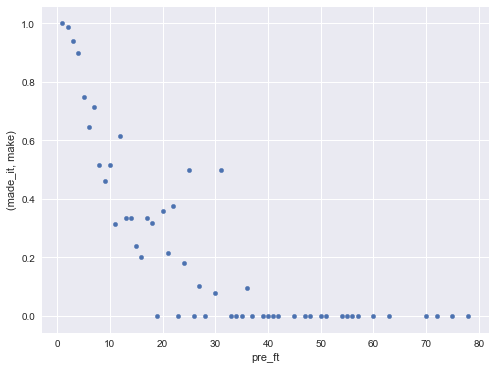

In [192]:
# plot results

putt_stats.plot(kind='scatter', x='pre_ft', y=('made_it', 'make'))

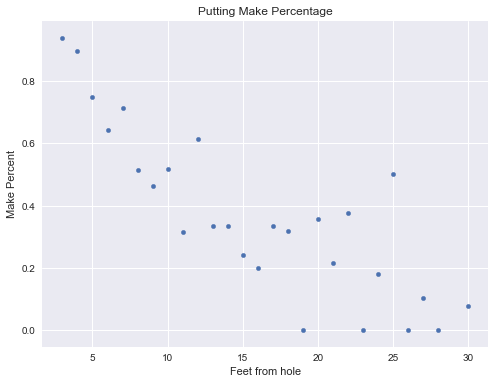

In [190]:
# focus on 2-30 foot range

putts_2to30 = putts.query('pre_ft > 2 & pre_ft <= 30').groupby('pre_ft') \
    .agg({ 'made_it': lambda x: sum(x) / len(x) }) \
    .reset_index()

plt.figure()
putts_2to30.plot(kind='scatter', x='pre_ft', y='made_it', title='Putting Make Percentage')
plt.xlabel('Feet from hole')
plt.ylabel('Make Percent')
plt.show()

In [153]:
# compute linear regression

res = smf.ols(formula='made_it ~ pre_ft', data=putts_2to30).fit()
res.params

Intercept    0.8206
pre_ft      -0.0282
dtype: float64

In [154]:
# bad putts (i.e., missed by more than 4, 6 feet)

g = putts.groupby('round_date')

miss_summary = g['post_ft'].agg({
    'putts': len,
    'miss_gt_4': lambda x: (x >= 4).sum(),
    'miss_gt_6': lambda x: (x >= 6).sum(),
})

miss_summary.head(10)

,putts,miss_gt_4,miss_gt_6
round_date,,,
2016-06-23,30.0,1.0,1.0
2016-06-24,30.0,1.0,1.0
2016-06-25,26.0,1.0,0.0
2016-06-26,25.0,2.0,1.0
2016-06-30,33.0,3.0,0.0
2016-07-01,34.0,2.0,1.0
2016-07-07,30.0,3.0,2.0
2016-07-08,32.0,2.0,1.0
2016-08-18,31.0,5.0,0.0


In [155]:
miss_summary.describe()

,putts,miss_gt_4,miss_gt_6
count,49.0000,49.0000,49.0000
mean,28.3469,1.2041,0.5102
std,2.1942,1.1722,0.7107
min,23.0000,0.0000,0.0000
25%,27.0000,0.0000,0.0000
50%,28.0000,1.0000,0.0000
75%,30.0000,2.0000,1.0000
max,34.0000,5.0000,2.0000


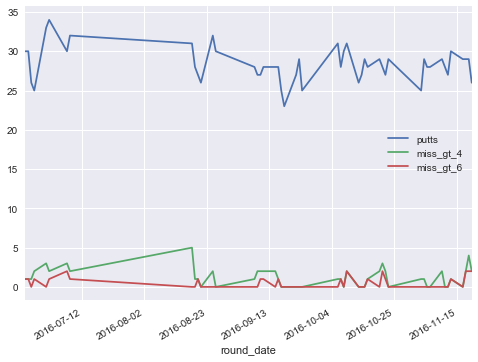

In [156]:
miss_summary.plot()

In [157]:
# misses under 10 feet

miss_lt_10 = putts.query('pre_ft <= 10 & made_it == False').copy()
miss_lt_10.groupby('direction').size().sort_values(ascending=False)

direction
right         53
left          43
long right     9
long left      3
short left     2
short          1
dtype: int64

In [158]:
# seems like more misses to the right
# is it statistically significant --> NO

n = len(miss_lt_10)
z = ((53 + 9) - (n / 2)) / sqrt(.5 * .5 * 111)
z

1.2339053944782488

In [159]:
# approach game

approach = df.query('club != "driver" & club != "putter"').copy()
approach = approach.query('pre_yd >= 50 & pre_yd < 250')
approach = approach.query('lie_before != "Tee" & par != 3')

print(len(approach))
print(approach.groupby('lie_before').size())

688
lie_before
Fairway               456
Fairway Bunker         26
Greenside Bunker        1
Intermediate Rough     90
Other                   8
Rough                 107
dtype: int64


In [160]:
# approach accuracy by yards away (10 yard bins)

g = approach.groupby('pre_yd_bin10')

a_summary = g['post_ft'].agg({
    'shots': len,
    'mean': np.mean,
    'median': np.median,
    'std': np.std,
})

a_summary

,shots,mean,median,std
pre_yd_bin10,,,,
50,17.0,22.5882,9.0,29.4301
60,21.0,20.9048,12.0,24.5762
70,23.0,14.8696,10.0,11.3189
80,24.0,23.7083,12.0,25.1629
90,25.0,21.4000,20.0,16.5957
100,36.0,16.6111,16.0,9.6814
110,24.0,19.9130,16.0,12.5876
120,52.0,18.2500,15.0,14.0068
130,42.0,27.9524,21.5,34.4376


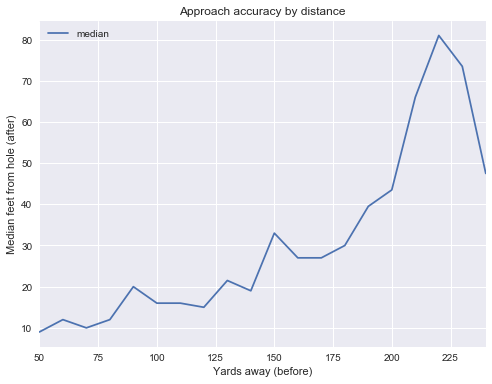

In [182]:
# plot results

plt.figure()
a_summary.plot(y=['median'], title='Approach accuracy by distance')
plt.xlabel('Yards away (before)')
plt.ylabel('Median feet from hole (after)')
plt.show()

In [187]:
# zoom in on 210-240, look at club selection

approach.query('pre_yd >= 210 & pre_yd < 240 & post_yd < 40') \
    .groupby('club')['post_ft'] \
    .agg({ 'n': len, 'med': np.median, 'mean': np.mean })

,n,med,mean
club,,,
fw wood,7.0,33.0,49.8571
hybrid,7.0,33.0,36.1429
iron,21.0,60.0,57.9524


In [163]:
# what's the loss of accuracy / cost to scoring of the rough?

lies = ['Fairway', 'Intermediate Rough', 'Rough']
fair_v_rough = approach[
    (approach.lie_before.isin(lies)) &
    (approach.pre_yd < 200)
].copy()

In [164]:
# mean / median distance to hole after approach, grouped by lie

g = fair_v_rough.groupby(['lie_before'])

g['post_ft'].agg({
    'shots': len,
    'mean': np.mean,
    'median': np.median,
})

,shots,mean,median
lie_before,,,
Fairway,399.0,23.4211,18.0
Intermediate Rough,85.0,26.4118,21.0
Rough,81.0,78.2000,45.0


In [165]:
# group by lie and distance

g = fair_v_rough.groupby(['pre_yd_bin25', 'lie_before'])

g['post_ft'].agg({
    'shots': len,
    'median': np.median,
}).unstack()

shots                           median                          
lie_before   Fairway Intermediate Rough Rough Fairway Intermediate Rough  Rough
pre_yd_bin25                                                                   
50              25.0               11.0  12.0     8.0                7.0   26.5
75              48.0                9.0   3.0    13.5               21.0   27.0
100             65.0               11.0   9.0    16.0               12.0   21.5
125             86.0               19.0  14.0    15.0               24.0   46.5
150             91.0               16.0  23.0    27.0               25.5   45.0
175             84.0               19.0  20.0    27.0               42.0  102.0

In [166]:
# what's the scoring difference of fairway vs. rough

g = fair_v_rough.groupby(['lie_before'])

g['score_norm'].agg({ 'shots': len, 'mean': np.mean })

,shots,mean
lie_before,,
Fairway,399,-0.1378
Intermediate Rough,85,-0.2000
Rough,81,0.3827


In [167]:
# scoring distance, by lie and distance

scoring = fair_v_rough.pivot_table(
    'score_norm',
    index=['pre_yd_bin25'],
    columns=['lie_before'],
    aggfunc=np.mean,
    fill_value=0
)

scoring['diff'] = scoring['Rough'] - scoring['Fairway']
scoring

lie_before,Fairway,Intermediate Rough,Rough,diff
pre_yd_bin25,,,,
50,-0.2800,-0.3636,0.3333,0.6133
75,-0.0417,-0.1111,0.0000,0.0417
100,-0.2308,-0.5455,0.5556,0.7863
125,-0.1628,-0.2632,0.2857,0.4485
150,-0.0879,-0.2500,0.4348,0.5227
175,-0.1071,0.1579,0.4000,0.5071


In [168]:
# look at driver misses

locs = ['center', 'left', 'right']
drives = df.query('club == "driver" & direction == {}'.format(locs)).copy()

g = drives.groupby('direction')
g.size() / g.size().sum()

direction
center    0.6430
left      0.1472
right     0.2098
dtype: float64

In [169]:
# scoring, broken down by drive direction

g['score_norm'].agg({
    'mean': np.mean,
    'std': np.std,
    'drives': len,
})

,mean,std,drives
direction,,,
center,-0.2421,0.6158,380
left,0.1264,1.0321,87
right,0.2177,0.8794,124


direction  center  left  right  total  center_p  left_p  right_p
hole_norm                                                       
0              26     5      7     38    0.6842  0.1316   0.1842
1              16    11      6     33    0.4848  0.3333   0.1818
2              26     8      9     43    0.6047  0.1860   0.2093
3              10     4      3     17    0.5882  0.2353   0.1765
4              19     7     12     38    0.5000  0.1842   0.3158
5              22     4      9     35    0.6286  0.1143   0.2571
6              18     2      2     22    0.8182  0.0909   0.0909
7              17     3      4     24    0.7083  0.1250   0.1667
8              33     2     11     46    0.7174  0.0435   0.2391
9              27     2      5     34    0.7941  0.0588   0.1471
10             18     4      6     28    0.6429  0.1429   0.2143
11             24     8      7     39    0.6154  0.2051   0.1795
12             15     3      7     25    0.6000  0.1200   0.2800
13             24     5  

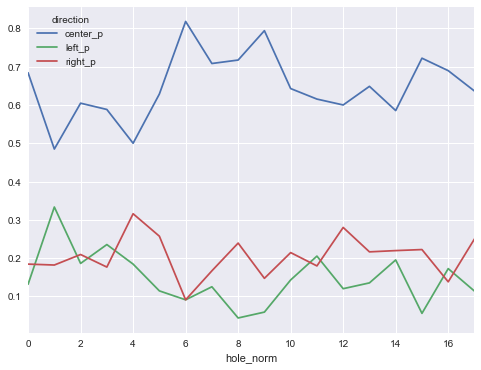

In [170]:
# any relationship between when horsey misses fairway over the course of a round?

by_hole = drives.groupby(['hole_norm', 'direction']).size().unstack()
by_hole['total'] = by_hole.sum(axis=1)

for c in ['center', 'left', 'right']:
    by_hole['{}_p'.format(c)] = by_hole[c] * 1.0 / by_hole.total

print(by_hole)
by_hole.ix[:, -3:].plot()

In [171]:
# par 5 analysis -- what's the difference scoring when going for it vs. not

LAYUP_THRESHOLD = 40 # yards
par5 = df.query('par == 5').copy()
par5_s2 = df.query('par == 5 & shot_no == 2').copy()

par5_s2['went_for_it'] = par5_s2['post_yd'] < LAYUP_THRESHOLD
par5_s2.groupby('went_for_it')['score_norm'].agg({ 'num': len, 'avg': np.mean, 'std': np.std })

,num,avg,std
went_for_it,,,
False,122,-0.2377,0.7164
True,48,-0.7708,0.5550


In [172]:
# going for it vs. not, broken down by lie

g = par5_s2.groupby(['lie_before', 'went_for_it'])
s2_lie = g['score_norm'].agg({ 'num': len, 'avg': np.mean }).unstack()
s2_lie['diff'] = s2_lie['avg', True] - s2_lie['avg', False]

s2_lie

num           avg            diff
went_for_it        False  True   False    True        
lie_before                                            
Fairway             65.0  40.0 -0.3231 -0.7500 -0.4269
Fairway Bunker       4.0   NaN  0.0000     NaN     NaN
Intermediate Rough  25.0   7.0 -0.4800 -0.8571 -0.3771
Other                3.0   NaN  0.0000     NaN     NaN
Rough               25.0   1.0  0.1600 -1.0000 -1.1600

In [173]:
# going for it vs. not, broken down by distance

g = par5_s2.groupby(['pre_yd_bin25', 'went_for_it'])
s2_dist = g['score_norm'].agg({ 'num': len, 'avg': np.mean }).unstack()
s2_dist['num'] =  s2_dist['num'].fillna(0)
s2_dist['score_diff'] = s2_dist['avg', True] - s2_dist['avg', False]

s2_dist

num           avg         score_diff
went_for_it  False  True   False    True           
pre_yd_bin25                                       
175            1.0   4.0  0.0000 -0.7500    -0.7500
200            3.0   3.0 -1.0000 -1.0000     0.0000
225            6.0  17.0 -0.1667 -0.8235    -0.6569
250           24.0  18.0 -0.2917 -0.6667    -0.3750
275           39.0   6.0 -0.3077 -0.8333    -0.5256
300           21.0   0.0 -0.3810     NaN        NaN
325           20.0   0.0  0.0500     NaN        NaN
350            6.0   0.0 -0.1667     NaN        NaN
375            2.0   0.0  1.0000     NaN        NaN

In [174]:
# compute strokes gained statistic

sg = df.copy()

sg.sort_values(by=['round_date', 'round_no', 'hole_no', 'shot_no'], ascending=[1, 1, 1, 1], inplace=True)
sg.reset_index(inplace=True, drop=True)
sg = sg.reset_index()

sg['has_next_shot'] = sg['shot_no'] != sg['score']
sg['next_shot_idx'] = sg.apply(lambda r: r['index'] + 1 if r['has_next_shot'] else -1, axis=1)
sg['shots_left'] = sg['score'] - sg['shot_no'] + 1

sg.head()

,index,round_date,round_no,hole_no,shot_no,putt,completed,left_to_pin_before,left_to_pin_after,penalty,player_name,name,course_id,start_tee,score,par,yards,lie_after,lie_before,club,direction,is_putt,score_norm,hole_norm,pre_ft,pre_yd,pre_ft_bin5,pre_yd_bin10,pre_yd_bin25,post_ft,post_yd,post_ft_bin5,post_yd_bin10,post_yd_bin25,has_next_shot,next_shot_idx,shots_left
0,0,2016-06-23,1,1,1,NaN,True,12672,4644.0,NaN,David Horsey,BMW International Open,63,10,3,4,357,Rough,Tee,iron,right,False,-1,9,1056.0,352.0,1055,350,350,387.0000,129.0000,385.0,120.0,125.0,True,1,3
1,1,2016-06-23,1,1,2,False,True,4644,72.0,NaN,David Horsey,BMW International Open,63,10,3,4,357,Green,Rough,iron,long,False,-1,9,387.0,129.0,385,120,125,6.0000,2.0000,5.0,0.0,0.0,True,2,2
2,2,2016-06-23,1,1,3,True,True,72,1.0,NaN,David Horsey,BMW International Open,63,10,3,4,357,Hole,Green,putter,center,True,-1,9,6.0,2.0,5,0,0,0.0833,0.0278,0.0,0.0,0.0,False,-1,1
3,3,2016-06-23,1,2,1,NaN,True,15120,5436.0,NaN,David Horsey,BMW International Open,63,10,4,4,425,Fairway,Tee,driver,right,False,0,10,1260.0,420.0,1260,420,400,453.0000,151.0000,450.0,150.0,150.0,True,4,4
4,4,2016-06-23,1,2,2,NaN,True,5436,360.0,NaN,David Horsey,BMW International Open,63,10,4,4,425,Green,Fairway,iron,short,False,0,10,453.0,151.0,450,150,150,30.0000,10.0000,30.0,10.0,0.0,True,5,3


In [175]:
# categorize shots (to facilitate computing baseline average score given situation)

def categorize(row):
    is_putt = row.is_putt
    ft, ft5, yds25 = list(map(round, [row.pre_ft, row.pre_ft_bin5, row.pre_yd_bin25]))
    
    if is_putt:
        return 'p_{}_ft'.format(ft if ft < 10 else '{}_to_{}'.format(ft5, ft5 + 5))
    else:
        return 'o_{}_to_{}_yds'.format(yds25, yds25 + 25)

sg['category'] = sg.apply(categorize, axis=1)

In [176]:
# check that category values seem reasonable

cols = ['round_no', 'hole_no', 'shot_no', 'lie_before', 'pre_yd', 'category']
sg[cols].head(10)

,round_no,hole_no,shot_no,lie_before,pre_yd,category
0,1,1,1,Tee,352.0000,o_350_to_375_yds
1,1,1,2,Rough,129.0000,o_125_to_150_yds
2,1,1,3,Green,2.0000,p_6_ft
3,1,2,1,Tee,420.0000,o_400_to_425_yds
4,1,2,2,Fairway,151.0000,o_150_to_175_yds
5,1,2,3,Green,10.0000,p_30_to_35_ft
6,1,2,4,Green,0.3333,p_1_ft
7,1,3,1,Tee,540.0000,o_525_to_550_yds
8,1,3,2,Intermediate Rough,276.0000,o_275_to_300_yds
9,1,3,3,Fairway,133.0000,o_125_to_150_yds


In [177]:
# compute average # of shots left, grouped by category
# (this is the baseline for shots gained stat) 

sg_baseline = sg.groupby('category').agg({ 'shots_left': np.mean })

# convert to dict
baseline_lookup = sg_baseline.to_dict()['shots_left']
baseline_lookup['done'] = 0

sg_baseline.head()

,shots_left
category,
o_0_to_25_yds,2.2700
o_100_to_125_yds,2.7556
o_125_to_150_yds,2.8134
o_150_to_175_yds,2.9844
o_175_to_200_yds,3.0854


In [178]:
# join with itself to get category of next_shot (if available)

sg2 = pd.merge(
    sg,
    sg[['index', 'category', 'shots_left']],
    how='left',
    left_on='next_shot_idx',
    right_on='index',
    suffixes=('', '_next')
)
sg2.drop('index_next', axis=1, inplace=True)
sg2.category_next.fillna('done', inplace=True)

# handle cases where shot cost 2 strokes (i.e., had a penalty)
sg2.shots_left_next = sg2.shots_left_next.fillna(0).astype(int)
sg2['shots'] = sg2['shots_left'] - sg2['shots_left_next']

# add baseline #s to df, compute strokes gained per shot
sg2['baseline'] = sg2['category'].apply(lambda x: baseline_lookup[x])
sg2['baseline_next'] = sg2['category_next'].apply(lambda x: baseline_lookup[x])
sg2['strokes_gained'] = sg2['baseline'] - sg2['baseline_next'] - sg2['shots']

In [179]:
# check how things look

cols = [
    'round_date', 'round_no', 'hole_no', 'shot_no', 'score', 'par', 'club', 'lie_before',
    'category', 'category_next', 'baseline', 'baseline_next', 'strokes_gained', 'pre_ft',
]

sg2 = sg2[cols]
sg2.head()

,round_date,round_no,hole_no,shot_no,score,par,club,lie_before,category,category_next,baseline,baseline_next,strokes_gained,pre_ft
0,2016-06-23,1,1,1,3,4,iron,Tee,o_350_to_375_yds,o_125_to_150_yds,3.8302,2.8134,0.0168,1056.0
1,2016-06-23,1,1,2,3,4,iron,Rough,o_125_to_150_yds,p_6_ft,2.8134,1.3778,0.4357,387.0
2,2016-06-23,1,1,3,3,4,putter,Green,p_6_ft,done,1.3778,0.0000,0.3778,6.0
3,2016-06-23,1,2,1,4,4,driver,Tee,o_400_to_425_yds,o_150_to_175_yds,3.9612,2.9844,-0.0232,1260.0
4,2016-06-23,1,2,2,4,4,iron,Fairway,o_150_to_175_yds,p_30_to_35_ft,2.9844,2.0000,-0.0156,453.0


In [180]:
# 10 best shots

sg2.sort_values(by='strokes_gained', ascending=False).head(10)

,round_date,round_no,hole_no,shot_no,score,par,club,lie_before,category,category_next,baseline,baseline_next,strokes_gained,pre_ft
2529,2016-10-23,4,5,3,3,5,iron,Fairway,o_25_to_50_yds,done,2.7188,0.0000,1.7188,93.0
2546,2016-10-23,4,10,3,3,4,putter,Green Fringe,o_0_to_25_yds,done,2.2700,0.0000,1.2700,15.0
1422,2016-09-17,3,1,4,4,5,putter,Green Fringe,o_0_to_25_yds,done,2.2700,0.0000,1.2700,15.0
1210,2016-09-10,3,17,3,3,4,putter,Green Fringe,o_0_to_25_yds,done,2.2700,0.0000,1.2700,15.0
2906,2016-11-10,1,16,2,2,3,wedge,Fairway,o_0_to_25_yds,done,2.2700,0.0000,1.2700,27.0
1549,2016-09-18,4,17,3,3,4,putter,Green Fringe,o_0_to_25_yds,done,2.2700,0.0000,1.2700,12.0
2233,2016-10-15,3,16,2,2,3,putter,Green Fringe,o_0_to_25_yds,done,2.2700,0.0000,1.2700,24.0
1455,2016-09-17,3,10,2,2,3,wedge,Intermediate Rough,o_0_to_25_yds,done,2.2700,0.0000,1.2700,24.0
3069,2016-11-13,4,2,2,4,5,fw wood,Intermediate Rough,o_250_to_275_yds,p_6_ft,3.5532,1.3778,1.1754,822.0
1894,2016-10-07,2,17,2,3,4,iron,Fairway,o_200_to_225_yds,p_1_ft,3.1478,1.0000,1.1478,621.0


In [181]:
# 10 worst shots

sg2.sort_values(by='strokes_gained', ascending=False).tail(10)

,round_date,round_no,hole_no,shot_no,score,par,club,lie_before,category,category_next,baseline,baseline_next,strokes_gained,pre_ft
840,2016-08-21,4,12,2,6,5,fw wood,Fairway,o_250_to_275_yds,o_100_to_125_yds,3.5532,2.7556,-1.2024,765.0
1070,2016-09-08,1,17,1,6,4,driver,Tee,o_375_to_400_yds,o_200_to_225_yds,3.8986,3.1478,-1.2493,1194.0
3022,2016-11-12,3,9,2,6,5,iron,Fairway,o_225_to_250_yds,o_75_to_100_yds,3.3061,2.6721,-1.3660,708.0
1858,2016-10-07,2,7,3,4,4,putter,Green,p_10_to_15_ft,p_30_to_35_ft,1.5221,2.0000,-1.4779,10.0
954,2016-08-26,2,4,4,7,5,iron,Rough,o_100_to_125_yds,o_0_to_25_yds,2.7556,2.2700,-1.5145,333.0
1756,2016-09-24,3,18,2,5,4,iron,Intermediate Rough,o_200_to_225_yds,o_75_to_100_yds,3.1478,2.6721,-1.5243,648.0
889,2016-08-25,1,7,1,6,3,iron,Tee,o_175_to_200_yds,o_100_to_125_yds,3.0854,2.7556,-1.6701,531.0
287,2016-06-30,1,3,1,7,5,driver,Tee,o_550_to_575_yds,o_550_to_575_yds,4.5536,4.5536,-2.0000,1659.0
432,2016-07-07,1,1,1,8,4,driver,Tee,o_425_to_450_yds,o_425_to_450_yds,4.0427,4.0427,-2.0000,1317.0
3005,2016-11-12,3,5,3,8,4,wedge,Other,o_150_to_175_yds,o_150_to_175_yds,2.9844,2.9844,-2.0000,450.0
